# Bias Detection using BERT

This notebook implements a BERT-based model for detecting political bias in news articles. The implementation includes:
- Loading data from the original Article-Bias-Prediction repository
- Training a BERT model with memory-efficient batching
- Saving checkpoints to Google Drive
- Real-time training monitoring

## Setup
First, let's install the required packages and set up Google Drive access.

In [1]:
# Install required packages
!pip install torch transformers numpy pandas scikit-learn matplotlib seaborn tqdm fastparquet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 733.0 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.9/101.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 35.1 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 25.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 34.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 32.0 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 18.8 MB

In [3]:
# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Create directories for saving model checkpoints
import os
CHECKPOINT_DIR = '/workspace/bigbird_checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [4]:
# Clone the original repository
!git clone https://github.com/ramybaly/Article-Bias-Prediction.git
DATA_DIR = 'Article-Bias-Prediction/data/jsons'

fatal: destination path 'Article-Bias-Prediction' already exists and is not an empty directory.


## Imports and Constants

In [6]:
import json
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
# from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import BigBirdForSequenceClassification, BigBirdTokenizer, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import display, clear_output

# Constants
RANDOM_STATE = 42
MAX_LENGTH = 512  # BERT's maximum sequence length
BATCH_SIZE = 16   # Can use larger batches than Longformer
EPOCHS = 10
LEARNING_RATE = 2e-5

# Ensure we're using GPU
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

# Set memory efficient options
torch.cuda.empty_cache()
if DEVICE.type == 'cuda':
    torch.backends.cudnn.benchmark = True

ModuleNotFoundError: No module named 'transformers'

## Helper Classes

In [5]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.best_model = None
        self.should_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = self._save_model_state(model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        else:
            self.best_loss = val_loss
            self.best_model = self._save_model_state(model)
            self.counter = 0
    
    def _save_model_state(self, model):
        return {k: v.cpu().clone() for k, v in model.state_dict().items()}
    
    def get_best_model(self, model):
        if self.best_model is not None:
            model.load_state_dict(self.best_model)
        return model

class ArticleDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

## Data Loading and Processing

In [7]:
def load_articles():
    articles = []
    for filename in os.listdir(DATA_DIR):
        if filename.endswith('.json'):
            with open(os.path.join(DATA_DIR, filename), 'r', encoding='utf-8') as f:
                article = json.load(f)
                articles.append(article)
    return pd.DataFrame(articles)

print("Loading articles...")
parquet_path = "/workspace/articles.parquet"
if os.path.isfile(parquet_path):
    df = pd.read_parquet(parquet_path)
else:
    df = load_articles()
    df.to_parquet(parquet_path)
print(f"Loaded {len(df)} articles")

# Display class distribution
print("\nClass Distribution:")
print(df['bias'].value_counts())

Loading articles...
Loaded 37554 articles

Class Distribution:
bias
2    13734
0    13005
1    10815
Name: count, dtype: int64


## Training Functions

In [9]:
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    
    progress_bar = tqdm(data_loader, desc='Training')
    for batch in progress_bar:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        # Clear memory
        del outputs
        torch.cuda.empty_cache()
    
    return total_loss / len(data_loader)

def evaluate_model(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    total_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            total_loss += loss.item()
            
            _, preds = torch.max(outputs.logits, dim=1)
            
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
            
            # Clear memory
            del outputs
            torch.cuda.empty_cache()
    
    return predictions, actual_labels, total_loss / len(data_loader)

def plot_confusion_matrix(y_true, y_pred, epoch):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, 
                annot=True, 
                fmt='d',
                cmap='Blues',
                xticklabels=['Left', 'Center', 'Right'],
                yticklabels=['Left', 'Center', 'Right'])
    plt.title(f'Confusion Matrix - BERT (Epoch {epoch})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

## Model Training

Initializing BERT model and tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training on cuda...

Epoch 1/10

GPU Memory Usage:
Mon Feb 17 20:21:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


|   0  NVIDIA RTX 4000 Ada Gene...    On  |   00000000:C1:00.0 Off |                  Off |
| 30%   31C    P2             14W /  130W |     637MiB /  20475MiB |      6%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+------------------------+----------------------+
                                                                                         
+-----------------------------------------------------------------------------------------+
| Processes:                                                                              |
|  GPU   GI   CI        PID   Type   Process name                              GPU Memory |
|        ID   ID                                                               Usage      |
|=========================================================================================|
+---------------------------------------------------------------------------------

Training:   0%|          | 0/1878 [00:00<?, ?it/s]

Average training loss: 0.6397


Evaluating:   0%|          | 0/470 [00:00<?, ?it/s]


Validation Loss: 0.4901
Validation Accuracy: 0.7994

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.86      0.79      2601
           1       0.90      0.74      0.81      2163
           2       0.81      0.79      0.80      2747

    accuracy                           0.80      7511
   macro avg       0.81      0.80      0.80      7511
weighted avg       0.81      0.80      0.80      7511



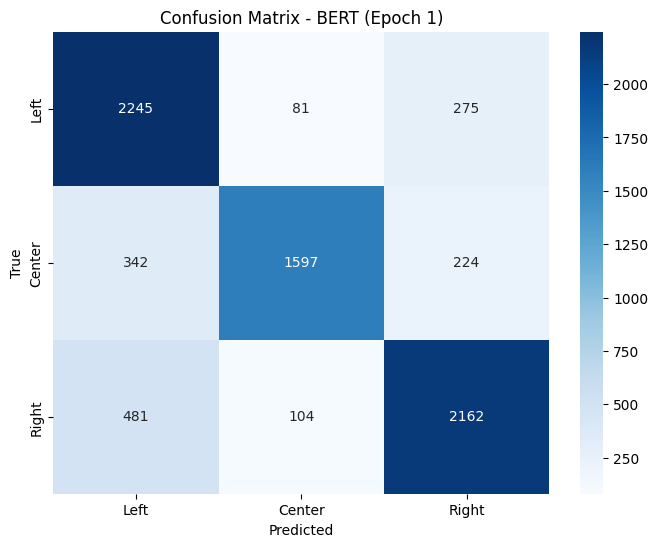


Epoch 2/10

GPU Memory Usage:
Mon Feb 17 20:58:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 4000 Ada Gene...    On  |   00000000:C1:00.0 Off |                  Off |
| 30%   52C    P2             32W /  130W |    2433MiB /  20475MiB |      1%      Default |
|                                         |                        |                  N/A |
+----------------

Training:   0%|          | 0/1878 [00:00<?, ?it/s]

Average training loss: 0.4100


Evaluating:   0%|          | 0/470 [00:00<?, ?it/s]


Validation Loss: 0.4486
Validation Accuracy: 0.8224

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      2601
           1       0.81      0.83      0.82      2163
           2       0.84      0.80      0.82      2747

    accuracy                           0.82      7511
   macro avg       0.82      0.82      0.82      7511
weighted avg       0.82      0.82      0.82      7511



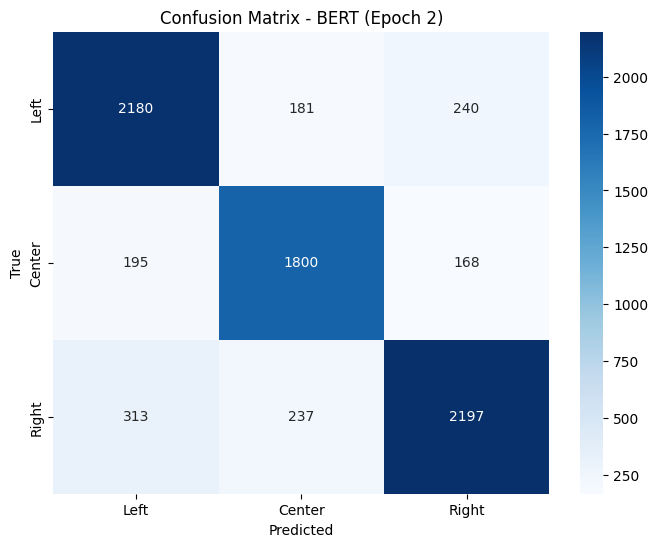


Epoch 3/10

GPU Memory Usage:
Mon Feb 17 21:35:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 4000 Ada Gene...    On  |   00000000:C1:00.0 Off |                  Off |
| 30%   52C    P2             33W /  130W |    2313MiB /  20475MiB |      0%      Default |
|                                         |                        |                  N/A |
+----------------

Training:   0%|          | 0/1878 [00:00<?, ?it/s]

Average training loss: 0.2911


Evaluating:   0%|          | 0/470 [00:00<?, ?it/s]


Validation Loss: 0.4520
Validation Accuracy: 0.8357

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      2601
           1       0.79      0.86      0.83      2163
           2       0.83      0.84      0.84      2747

    accuracy                           0.84      7511
   macro avg       0.84      0.84      0.84      7511
weighted avg       0.84      0.84      0.84      7511



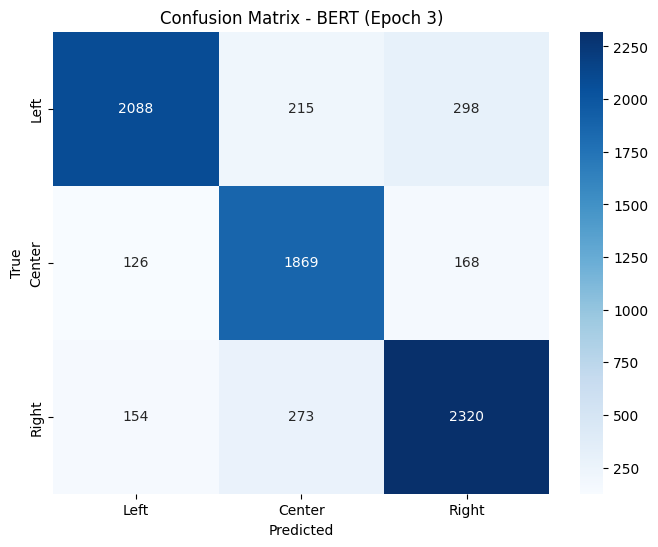


Epoch 4/10

GPU Memory Usage:
Mon Feb 17 22:12:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 4000 Ada Gene...    On  |   00000000:C1:00.0 Off |                  Off |
| 30%   52C    P2             33W /  130W |    2253MiB /  20475MiB |      0%      Default |
|                                         |                        |                  N/A |
+----------------

Training:   0%|          | 0/1878 [00:00<?, ?it/s]

Average training loss: 0.1911


Evaluating:   0%|          | 0/470 [00:00<?, ?it/s]


Validation Loss: 0.4693
Validation Accuracy: 0.8410

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      2601
           1       0.83      0.85      0.84      2163
           2       0.81      0.88      0.85      2747

    accuracy                           0.84      7511
   macro avg       0.84      0.84      0.84      7511
weighted avg       0.84      0.84      0.84      7511



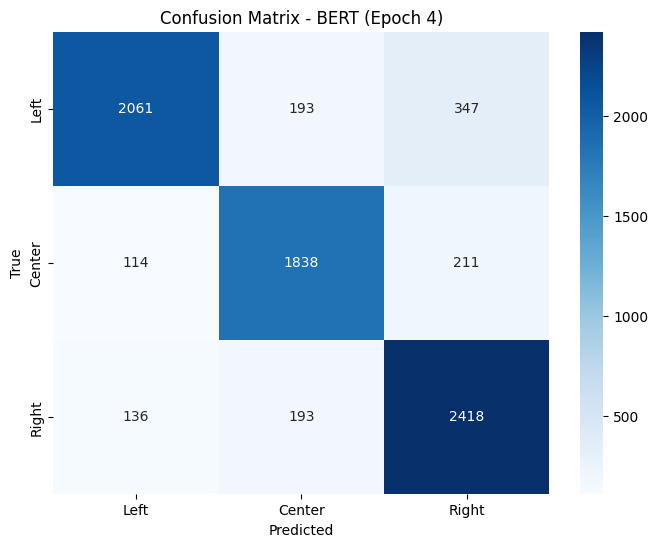


Epoch 5/10

GPU Memory Usage:
Mon Feb 17 22:49:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 4000 Ada Gene...    On  |   00000000:C1:00.0 Off |                  Off |
| 30%   53C    P2             32W /  130W |    2139MiB /  20475MiB |      1%      Default |
|                                         |                        |                  N/A |
+----------------

Training:   0%|          | 0/1878 [00:00<?, ?it/s]

Average training loss: 0.1272


Evaluating:   0%|          | 0/470 [00:00<?, ?it/s]


Validation Loss: 0.5651
Validation Accuracy: 0.8309

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      2601
           1       0.78      0.88      0.83      2163
           2       0.87      0.79      0.83      2747

    accuracy                           0.83      7511
   macro avg       0.83      0.83      0.83      7511
weighted avg       0.83      0.83      0.83      7511



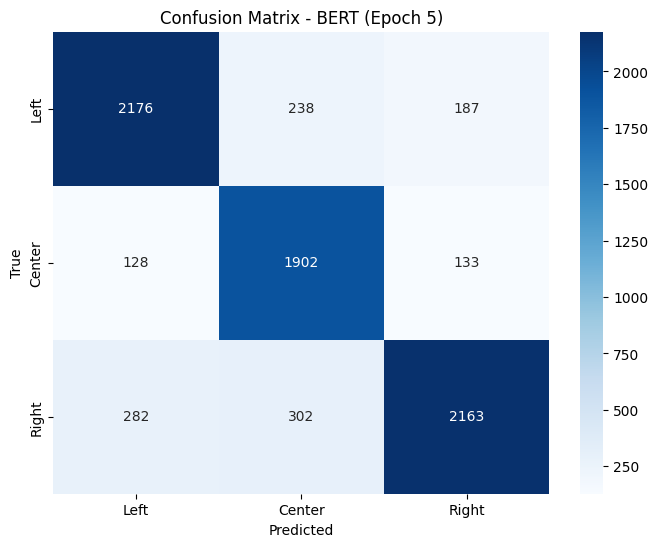


Early stopping triggered at epoch 5

Training completed!


In [10]:
# Prepare data
texts = df['content'].tolist()
labels = df['bias'].tolist()

# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=RANDOM_STATE, stratify=labels
)

# Initialize tokenizer and model
# print("Initializing BERT model and tokenizer...")
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load model on CPU first
# model = BertForSequenceClassification.from_pretrained(
#     'bert-base-uncased',
#     num_labels=3,
#     output_attentions=False,
#     output_hidden_states=False
# )

print("Initializing BigBird model and tokenizer...")
tokenizer = BigBirdTokenizer.from_pretrained('google/bigbird-roberta-base')
model = BigBirdForSequenceClassification.from_pretrained('google/bigbird-roberta-base', num_labels=3)

# Clear memory before moving to GPU
torch.cuda.empty_cache()
model.to(DEVICE)

# Create datasets and loaders
train_dataset = ArticleDataset(train_texts, train_labels, tokenizer, MAX_LENGTH)
val_dataset = ArticleDataset(val_texts, val_labels, tokenizer, MAX_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Initialize optimizer and early stopping
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
early_stopping = EarlyStopping(patience=3, min_delta=0.001)

# Training loop
print(f"Starting training on {DEVICE}...")
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    
    # Monitor GPU memory
    if DEVICE.type == 'cuda':
        print("\nGPU Memory Usage:")
        !nvidia-smi
    
    train_loss = train_epoch(model, train_loader, optimizer, DEVICE)
    print(f"Average training loss: {train_loss:.4f}")
    
    predictions, actual_labels, val_loss = evaluate_model(model, val_loader, DEVICE)
    
    # Early stopping check
    early_stopping(val_loss, model)
    
    # Calculate metrics
    accuracy = accuracy_score(actual_labels, predictions)
    print(f"\nValidation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(actual_labels, predictions))
    
    # Plot confusion matrix
    plot_confusion_matrix(actual_labels, predictions, epoch + 1)
    
    # Save checkpoint to Drive
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'accuracy': accuracy
    }
    torch.save(checkpoint, f"{CHECKPOINT_DIR}/checkpoint_epoch_{epoch+1}.pt")
    
    if early_stopping.should_stop:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

# Load the best model
model = early_stopping.get_best_model(model)

print("\nTraining completed!")

## Save Final Model

In [ ]:
# Save the final model to Drive
final_save_dir = f"{CHECKPOINT_DIR}/final_model"
os.makedirs(final_save_dir, exist_ok=True)

model.save_pretrained(final_save_dir)
tokenizer.save_pretrained(final_save_dir)

print(f"Final model saved to {final_save_dir}")

## Test Model Predictions

In [ ]:
def predict_bias(text, model, tokenizer, device):
    model.eval()
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=MAX_LENGTH,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
    
    bias_map = {0: 'left', 1: 'center', 2: 'right'}
    return bias_map[preds.item()]

# Test prediction on a sample article
sample_text = df['content'].iloc[0]
predicted_bias = predict_bias(sample_text, model, tokenizer, DEVICE)
print(f"Sample prediction - Predicted bias: {predicted_bias}")
print(f"Actual bias: {df['bias_text'].iloc[0]}")